In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime
import quandl
import sys
import urllib
import os
from matplotlib import pylab as plt 
import quandl
import seaborn as sns
import sys
from scipy.stats import norm

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [58]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index =  data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'Volatility': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics

In [49]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [45]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    
    return metrics 

## Breaking Bad trends

Re-creation of Harvey Campbells paper and methodology

to do
- Do 12 & 1 month momentum 
- Try the different weightings
- wan we optimize?




In [12]:
TICKS = ['SPY']
assets_df = pd.DataFrame()
for tick in TICKS:
    
    price = yf.download(tick,start='1980-01-01', progress = False, threads = False)
    
    log_ret = np.log(price['Adj Close'].pct_change()+1)
    price = pd.DataFrame(price['Adj Close'])
    
    #price['Asset'] = tick
    assets_df = pd.concat([assets_df,price] )

assets_df = assets_df.resample('M').last()

In [22]:
assets_df['12M'] = assets_df['Adj Close'].pct_change(12)
assets_df['1M'] = assets_df['Adj Close'].pct_change(1)
assets_df['ret'] = assets_df['Adj Close'].pct_change(1).shift(-1)

In [64]:
#Create signals

assets_df.loc[assets_df['12M']>0, '12m_sig'] = 1
assets_df.loc[assets_df['12M']<=0, '12m_sig'] = -1

assets_df.loc[assets_df['1M']>0, '1m_sig'] = 1
assets_df.loc[assets_df['1M']<=0, '1m_sig'] = -1


assets_df['Mix_sig'] = (assets_df['1m_sig'] + assets_df['12m_sig'])/2

In [67]:
assets_df['12m_strat'] = assets_df['ret']*assets_df['12m_sig']
assets_df['1m_strat'] = assets_df['ret']*assets_df['1m_sig']
assets_df['mix_strat'] = assets_df['ret']*assets_df['Mix_sig']


assets_df = assets_df.dropna()

assets_df["12m_strat"] = (assets_df["12m_strat"]+1).cumprod()
assets_df["1m_strat"] = (assets_df["1m_strat"]+1).cumprod()
assets_df["mix_strat"] = (assets_df["mix_strat"]+1).cumprod()
assets_df['comp'] = (assets_df["1M"]+1).cumprod()
result_cum = assets_df[["12m_strat", "1m_strat","mix_strat", "comp"]]

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR
12m_strat,9.50%,15.00%,0.630000,0.860000,-36.00%,0.260000
1m_strat,0.99%,15.30%,0.060000,0.100000,-42.00%,0.020000
mix_strat,5.71%,11.20%,0.510000,0.570000,-26.00%,0.220000
comp,9.78%,15.10%,0.650000,0.820000,-51.00%,0.190000


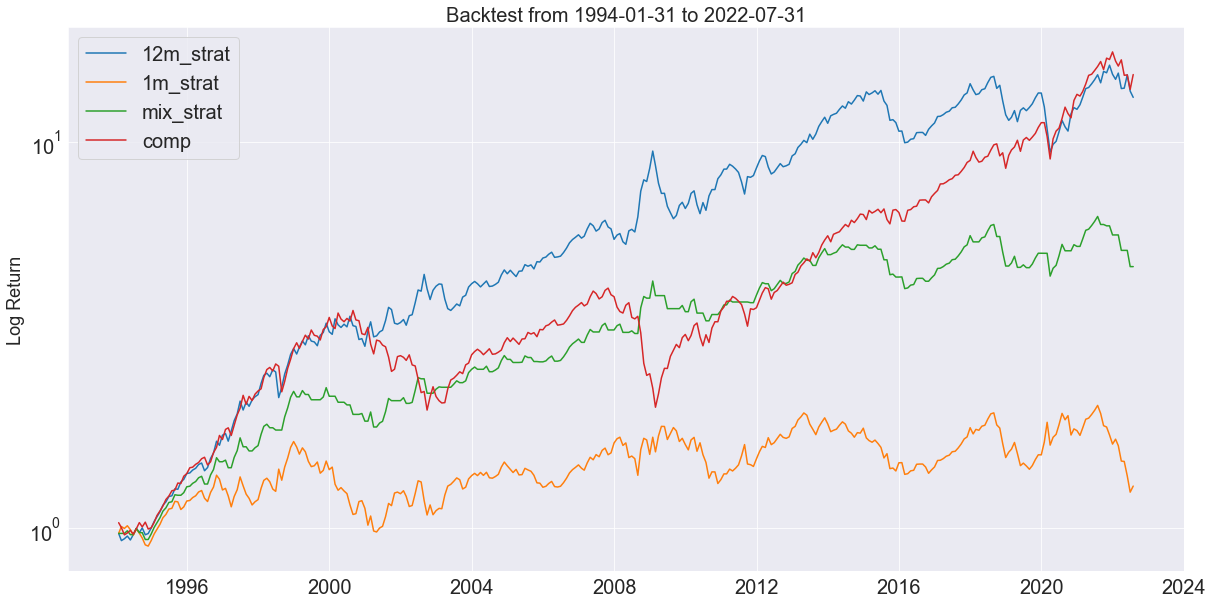

In [69]:


sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

strategy_evaluation(result_cum,result_cum.columns , freq = 'M')